# Disaster Response project: 
## Explorative Data Analysis

In [1]:
import pandas as pd
import numpy as np 
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from collections import Counter

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords

In [2]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql("SELECT * FROM DisasterResponse", engine)
category_names = df.columns[4:]

In [3]:
print("number of messages: ", df.shape[0])
print("number of categories: ", len(category_names))
print("genres: ", df.genre.unique())
df.head()

number of messages:  26216
number of categories:  36
genres:  ['direct' 'social' 'news']


id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   

                                            original   genre  related  \
0  Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                 Cyclone nan fini osinon li pa fini  direct        1   
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4  facade ouest d Haiti et le reste du pays aujou...  direct        1   

   request  offer  aid_related  medical_help  medical_products  ...  \
0        0      0            0             0                 0  ...   
1        0      0            1             0                 0  ...   
2        0      0            0             0                 0  ...   
3        1      0            1             0                 1  ...   
4        0      0            0             0                 0  ...   

   aid_centers  other_infrastructure  weather_related  floods  storm  fire  \
0            0                     0                0       0      0     0   
1            0                     0                1       0      1     0   
2            0                     0                0       0      0     0   
3            0                     0                0       0      0     0   
4            0                     0                0       0      0     0   

   earthquake  cold  other_weather  direct_report  
0           0     0              0              0  
1           0     0              0              0  
2           0     0              0              0  
3           0     0              0              0  
4           0     0              0              0  

[5 rows x 40 columns]

news      13054
direct    10766
social     2396
Name: genre, dtype: int64

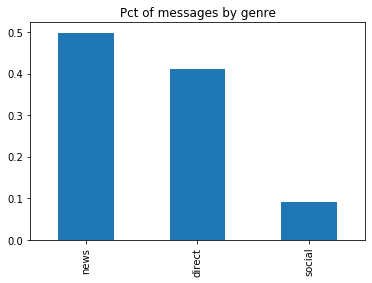

In [4]:
df.genre.value_counts(sort=True).div(df.genre.value_counts().sum(axis=0)).plot.bar();
plt.title("Pct of messages by genre");
df.genre.value_counts(sort=True)

In [5]:
#checking if genre categorization is mutually exclusive
#the sum across rows when one-hot-encoded should not be greater than 1, 
check_genres = (pd.get_dummies(df['genre']).sum(axis=1) > 1).sum()
if check_genres == 0:
    print("genres are mutually exlusive")
else:
    print("genres are not mutually exlusive")

genres are mutually exlusive


Commentary: I don't quite understand what 'genre' means in this project. Probably the channels where messages were gathered? So the majority of messages come from news/direct channels and only a small fraction from social channels. Moreover, the channel hypothesis seems to be supported by the fact that only one genre category could be assigned (i.e. the genre categorization is mutually exclusive).

What in this context then 'direct' means?? Coming from disaster-response realted NGOs?

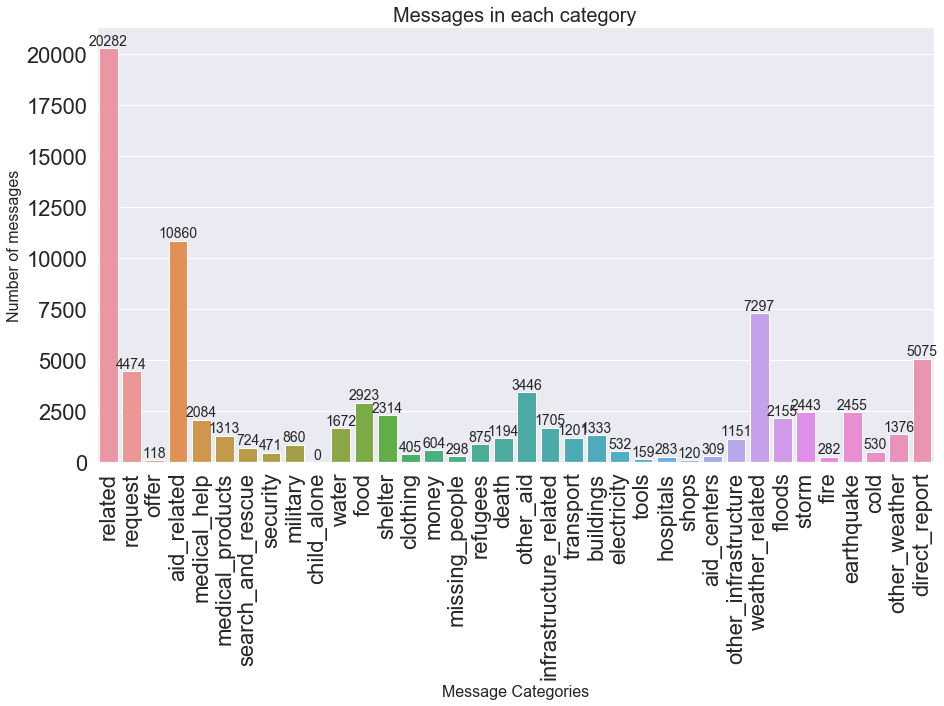

In [6]:
categories = list(df.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(categories[4:], df.iloc[:,4:].sum().values)
plt.title("Messages in each category", fontsize=20)
plt.ylabel('Number of messages', fontsize=16)
plt.xlabel('Message Categories', fontsize=16)
plt.xticks(rotation='vertical')

#adding the text labels
rects = ax.patches
labels = df.iloc[:,4:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=14)
plt.show()

**Commentary**: The most widespread category is "related" (~ 77%) followed by "aid_related" and "weather_related". 
<br>
"child_alone" category doesn't have any messages! This might cause problems with some models (like LogisticRegression)

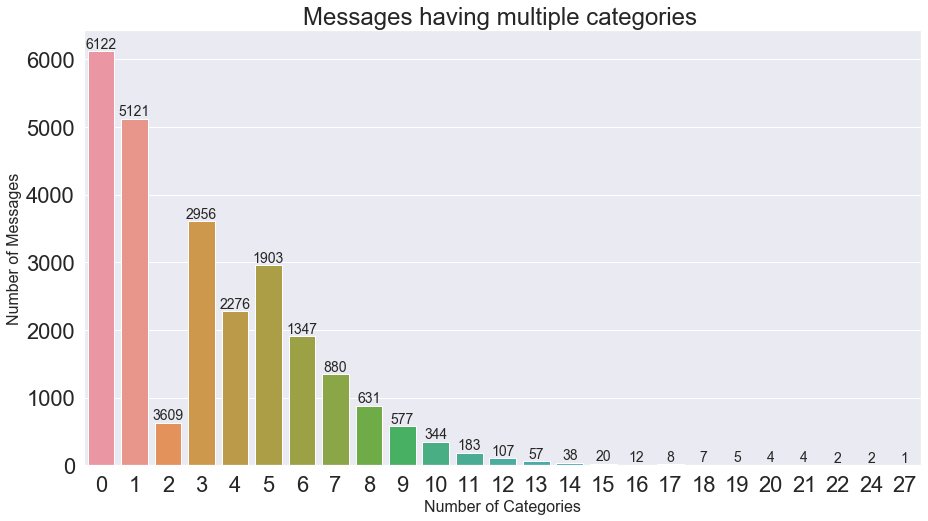

In [7]:
rowSums = df.iloc[:,4:].sum(axis=1)
multiCategory_counts = rowSums.value_counts()

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiCategory_counts.index, multiCategory_counts.values)
plt.title("Messages having multiple categories ")
plt.ylabel('Number of Messages', fontsize=16)
plt.xlabel('Number of Categories', fontsize=16)

#adding the text labels
rects = ax.patches
labels = multiCategory_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=14)
plt.show()

**Commentary**: Messages may have different number of categories assigned to them. As such the problem we face in this ML project is not only multi-category but also multi-label, meaning that the labels themselves are not mutually exclusive. This is especially helpful because it determines what models best suit to our problem.

From the above pic we see that there are also 6122 messages without any category - i.e. irrelavant messages. Let's see what kind of messages these are:

In [8]:
nocat_messages = df[rowSums == 0][['message', 'genre']]
nocat_messages.head()

message   genre
5              Information about the National Palace-  direct
8     I would like to receive the messages, thank you  direct
11  I am in Petionville. I need more information r...  direct
17  are you going to call me or do you want me to ...  direct
18     I don't understand how to use this thing 4636.  direct

In [9]:
print("pct of irrelevant messages by genre:")
print(round(nocat_messages.genre.value_counts(sort=False).div(df.genre.value_counts(sort=False))*100),2)

pct of irrelevant messages by genre:
direct    32.0
news      18.0
social    13.0
Name: genre, dtype: float64 2


In [10]:
# check if messages with 0 categories assigned is the same as category 'relevant' = 0
print("number of messages without any category:", df[df.related == 0].shape[0])
print("number of messages with 'relevant'=0 category:", df[rowSums == 0].shape[0])

(df[df.related == 0].id == df[rowSums == 0].id).sum()

number of messages without any category: 6122
number of messages with 'relevant'=0 category: 6122


6122

Commentary: seems like the above messages are indeed unrelated to urgent needs during disasters. Those that don't have any category assigned are the same that have 'relevant'=0. Almost every third message that is irrelevant is from "direct" genre.

Let's explore other extreme and see the messages that were labeled with more than 20 categories:

In [11]:
mostcat_messsages = df[rowSums > 20][['message', 'genre']]
mostcat_messsages.head()

message   genre
10171  Saw a documentary today about an earthquake in...  social
13671  Prior to this disaster, we experienced devasta...    news
14719  However, I must stress that the United Nations...    news
16032  The weather forecast indicates that rains shou...    news
16135  We are also striving to boost the capacity of ...    news

In [12]:
mostcat_messsages.genre.value_counts(sort=False)

news      8
social    1
Name: genre, dtype: int64

### Pct of categories across genres:

In [13]:
round((df.iloc[:, 3:].groupby(['genre']).sum().div(df.iloc[:, 3:].sum())*100),1).T

genre                   direct  news  social
aid_centers               25.2  70.6     4.2
aid_related               39.9  54.0     6.1
buildings                 29.3  62.2     8.5
child_alone                NaN   NaN     NaN
clothing                  61.0  33.3     5.7
cold                      11.9  78.3     9.8
death                     21.3  71.9     6.9
direct_report             71.2  16.8    12.0
earthquake                32.4  37.1    30.5
electricity               15.2  61.5    23.3
fire                      14.5  79.8     5.7
floods                    14.1  81.1     4.8
food                      61.8  34.5     3.7
genre                      NaN   NaN     NaN
hospitals                 19.1  71.4     9.5
infrastructure_related    19.2  72.1     8.7
medical_help              28.4  67.9     3.7
medical_products          35.9  60.4     3.7
military                   5.3  93.1     1.5
missing_people            28.9  55.4    15.8
money                     24.5  63.1    12.4
offer                     39.0  55.1     5.9
other_aid                 45.7  45.4     8.9
other_infrastructure      16.2  75.2     8.6
other_weather             15.0  76.5     8.5
refugees                  19.9  76.1     4.0
related                   36.7  52.8    10.5
request                   82.6  13.5     3.9
search_and_rescue         29.8  60.9     9.3
security                  27.8  62.0    10.2
shelter                   49.8  48.1     2.1
shops                     27.5  56.7    15.8
storm                     12.9  59.1    28.0
tools                     20.8  71.7     7.5
transport                 17.5  72.6     9.9
water                     50.0  47.2     2.8
weather_related           20.8  58.7    20.5

Commentary: seems like we can better predict the following categories - 'request', 'food', 'clothing', 'direct_report' - from direct genre than from other genres.

## Visualizing content of categorized tweets with WordCloud

In [14]:
#drop child_alone column because it doesn't contain any tweets and hence cannot be visualized:
df_nochildalone = df.drop(['child_alone'], axis=1)
category_names_upd = df_nochildalone.columns[5:]

Here I visualize only first 12 categories to get a general idea how different the tweets are by content:

In [15]:
plt.figure(figsize=(150, 600));

for i, category in enumerate(category_names_upd[:12]):
    print(f"processing {category}")
    plt.subplot(12,2,i+1)
    subset = df_nochildalone[df_nochildalone[category] == 1]
    text = subset.message.values
    tmp = WordCloud(stopwords=STOPWORDS, background_color='black', collocations=False, 
                   width=650, height=480).generate(" ".join(text));
    plt.axis('off')
    plt.title(category,fontsize=150)
    plt.imshow(tmp);

processing request
processing offer
processing aid_related
processing medical_help
processing medical_products
processing search_and_rescue
processing security
processing military
processing water
processing food
processing shelter
processing clothing


## Acknowledgement:

Several visualizations are inspired by this article: <br>
   Kartik Nooney: "Deep dive into multi-label classification..! (With detailed Case Study)", Medium, 2018/06/07,
   https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff


## TOP 20 word counts in the dataset

In [197]:
# Create a map between Treebank and WordNet 
from nltk.corpus import wordnet as wn

# WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r', ADJ_SAT = 'a'
# Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
tag_map = {
        'CC':None, # coordin. conjunction (and, but, or)  
        'CD':wn.NOUN, # cardinal number (one, two)             
        'DT':None, # determiner (a, the)                    
        'EX':wn.ADV, # existential ‘there’ (there)           
        'FW':None, # foreign word (mea culpa)             
        'IN':wn.ADV, # preposition/sub-conj (of, in, by)   
        'JJ':wn.ADJ, # adjective (yellow)                  
        'JJR':wn.ADJ, # adj., comparative (bigger)          
        'JJS':wn.ADJ, # adj., superlative (wildest)           
        'LS':None, # list item marker (1, 2, One)          
        'MD':None, # modal (can, should)                    
        'NN':wn.NOUN, # noun, sing. or mass (llama)          
        'NNS':wn.NOUN, # noun, plural (llamas)                  
        'NNP':wn.NOUN, # proper noun, sing. (IBM)              
        'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
        'PDT':wn.ADJ, # predeterminer (all, both)            
        'POS':None, # possessive ending (’s )               
        'PRP':None, # personal pronoun (I, you, he)     
        'PRP$':None, # possessive pronoun (your, one’s)    
        'RB':wn.ADV, # adverb (quickly, never)            
        'RBR':wn.ADV, # adverb, comparative (faster)        
        'RBS':wn.ADV, # adverb, superlative (fastest)     
        'RP':wn.ADJ, # particle (up, off)
        'SYM':None, # symbol (+,%, &)
        'TO':None, # “to” (to)
        'UH':None, # interjection (ah, oops)
        'VB':wn.VERB, # verb base form (eat)
        'VBD':wn.VERB, # verb past tense (ate)
        'VBG':wn.VERB, # verb gerund (eating)
        'VBN':wn.VERB, # verb past participle (eaten)
        'VBP':wn.VERB, # verb non-3sg pres (eat)
        'VBZ':wn.VERB, # verb 3sg pres (eats)
        'WDT':None, # wh-determiner (which, that)
        'WP':None, # wh-pronoun (what, who)
        'WP$':None, # possessive (wh- whose)
        'WRB':None, # wh-adverb (how, where)
        '$':None, #  dollar sign ($)
        '#':None, # pound sign (#)
        '“':None, # left quote (‘ or “)
        '”':None, # right quote (’ or ”)
        '(':None, # left parenthesis ([, (, {, <)
        ')':None, # right parenthesis (], ), }, >)
        ',':None, # comma (,)
        '.':None, # sentence-final punc (. ! ?)
        ':':None # mid-sentence punc (: ; ... – -)
    }

In [217]:
from nltk import pos_tag
import re

def tokenize(text):     
    ''' Tokenizer for CountVectorizer() 

        Inputs: 
            text: message instance
        Output: 
            clean_tokens: list of lemmatized tokens based on words from the message
    '''
    #remove url links
    re_url = r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    text = re.sub(re_url, 'urlplaceholder', text)

    #remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    
    tokens = word_tokenize(text)
    
    # remove short words
    tokens = [token for token in tokens if len(token) > 2]
    
    # remove stopwords
    STOPWORDS = list(set(stopwords.words('english')))
    tokens = [token for token in tokens if token not in STOPWORDS]

    pos_tokens = pos_tag(tokens) 

    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok, pos in pos_tokens:
        try:
            if tag_map[pos] is not None:
                clean_tok = lemmatizer.lemmatize(tok, tag_map[pos]).lower().strip()
                clean_tokens.append(clean_tok)
            else:
                clean_tok = lemmatizer.lemmatize(tok).lower().strip()
                clean_tokens.append(clean_tok)
        except KeyError:
            pass
            
    return clean_tokens

In [218]:
def compute_word_counts(messages, load=True, filepath='../data/counts.npz'):
    '''
    input: (
        messages: list or numpy array
        load: Boolean value if load or run model 
        filepath: filepath to save or load data
            )
    Function computes the top 20 words in the dataset with counts of each term
    output: (
        top_words: list
        top_counts: list 
            )
    '''
    
    if load:
        # load arrays
        data = np.load(filepath)
        return list(data['top_words']), list(data['top_counts'])
    else:
        # get top words 
        counter = Counter()
        for message in messages:
            tokens = tokenize(message)
            for token in tokens:
                counter[token] += 1
        # top 20 words 
        top = counter.most_common(20)
        top_words = [word[0] for word in top]
        top_counts = [count[1] for count in top]
        # save arrays
        np.savez(filepath, top_words=top_words, top_counts=top_counts)
        return list(top_words), list(top_counts)

In [219]:
compute_word_counts(df['message'].values, load=False)

(['water',
  'people',
  'food',
  'help',
  'need',
  'please',
  'earthquake',
  'say',
  'area',
  'like',
  'would',
  'flood',
  '000',
  'country',
  'know',
  'find',
  'also',
  'get',
  'government',
  'rain'],
 [3044,
  3013,
  2902,
  2844,
  2744,
  2053,
  1904,
  1851,
  1667,
  1535,
  1491,
  1293,
  1254,
  1250,
  1210,
  1165,
  1114,
  1094,
  1054,
  1042])